# Clothes  Image Classifier
Date: October 2, 2018


# Import Required Libraries
Importing required python libraries and set the default values

In [1]:

from sklearn.model_selection import train_test_split
from time import time
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
np.random.seed(sum(map(ord, "aesthetics")))


with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import h5py as h5py

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF','#67E568','#257F27','#08420D','#FFF000','#FFB62B','#E56124','#E53E30','#7F2353','#F911FF','#9F8CA6']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7)
sns.set_style('darkgrid')

# Read Data Files

In [3]:
# read training dataset
with h5py.File('input/images_training.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/labels_training.h5','r') as H:
    label = np.copy(H['label'])
    
# read testing dataset
with h5py.File('input/images_testing.h5','r') as H:
    data_test = np.copy(H['data'])
with h5py.File('input/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['label'])

In [4]:

nsamples, nx, ny = data.shape

#flatten the image matrices to one dimension array
d2_data = data.reshape(nsamples,nx*ny)
n_samples, h, d = data.shape
X = d2_data

y = label
n_features = X.shape[1]
u_labels= np.sort(pd.DataFrame(label)[0].unique())

print("total number of train/validation samples: {0}".format(n_samples))
print("number of features: {0}".format(n_features))
print("unique labels: {0}".format(u_labels))


total number of train/validation samples: 30000
number of features: 784
unique labels: [0 1 2 3 4 5 6 7 8 9]


Split train dataset to the train and validation sets

In [5]:

# split training dataset to test and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

prepare the test dataset

In [6]:

# read first 2000 records in the tes dataset
nsamples_t, nx_t, ny_t = data_test[:2000].shape
X_test = data_test[:2000].reshape(nsamples_t,nx_t*ny_t)

y_test = label_test

#prepare the full test set
nsamples_f, nx_f, ny_f = data_test.shape
X_test_full = data_test.reshape(nsamples_f,nx_f*ny_f)
#X_test_full = StandardScaler().fit_transform(X_test_full)

In [7]:
X_test_full.shape

(5000, 784)

# Softmax Regression Implementaion


In [8]:

def pca_func(X,h,w,comp,ds):
    """Helper function to apply PCA"""
    n_components = comp
    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)  
    eigen_comp = pca.components_.reshape((n_components, h, w)) #recreate images from lower dimensional linear space   
    print("Projecting {0} set input data on a lower dimensional linear space".format(ds))
    X_pca = pca.transform(X)
    return X_pca,eigen_comp

def loss_func(w,x,y):
    """Helper function to Calculate loss and update gradient"""
    m = x.shape[0]
    y_mat = one_hot_func(y) #convert the integer class coding into a one-hot representation
    scores = np.dot(x,w) #compute raw class scores given our input and current weights
    prob = softmax(scores) #perform a softmax on these scores to get their probabilities
    loss = (-1) * np.sum(y_mat * np.log(prob)) #find the loss of the probabilities
    grad = (-1) * np.dot(x.T,(y_mat - prob)) #compute the gradient for that loss    
    return loss,grad

def one_hot_func(Y):
    """Helper function to build one-hot lables"""
    m = Y.shape[0]
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T
    return OHX

def softmax(z):
    """Helper function to build softmax function"""
    z -= np.max(z) #normalise the data to get the output as a valid probability
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm

def prob_pred_func(someX):
    """Helper function to calculate probability and prediction"""
    probs = softmax(np.dot(someX,w_best))
    preds = np.argmax(probs,axis=1)
    return probs,preds

def accuracy_func(someX,someY):
    """Helper function to calculate accuracy"""
    probs,preds = prob_pred_func(someX)
    accuracy = sum(preds == someY)/(float(len(someY)))*100
    return accuracy,probs,preds

def accuracy_class_func(someY):
    """Helper function to calculate accuracy by class"""
    for i in range(10):
        a = y_test[y_test == someY]
        accuracy_t = len(a[a==(i)])/ len(y_test[y_test == (i)]) * 100
        print('Class ' + str(i) + ' Accuracy: {0:.3f} %'.format(accuracy_t))
    
def plot_gallery(images, titles, h, d, n_row, n_col):
    """Helper function to plot a gallery of portraits"""
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, d)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
   

## Principal component analysis (PCA)
PCA is (truncated) SVD on centered data (by per-feature mean substraction). If the data is already centered, those two classes will do the same.

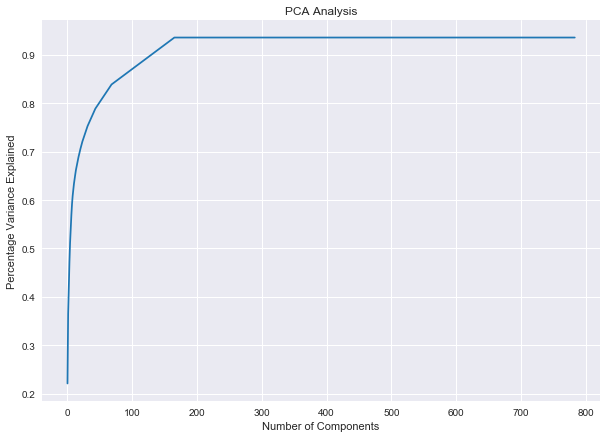

number of effective components : 166


In [9]:
# PCA component justification
scaled_x = StandardScaler().fit_transform(X)

# Now perform PCA
pca = PCA()
x_pca = pca.fit_transform(scaled_x)

# Look at the variance ratio cumlatively
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3))
plt.ylabel('Percentage Variance Explained')
plt.xlabel('Number of Components')
plt.title('PCA Analysis')
plt.plot(var)
plt.show()

ef = set(var)
print('number of effective components : {0}'.format(len(ef)))



the number effective components found in the previous step will be used to fit PCA

In [10]:
comp = len(ef)
X_full_pca, eigen_comp_full =  pca_func(X,h,d,comp,'full training')
X_train_pca, eigen_comp = pca_func(X_train,h,d,comp,'training')
X_val_pca , eigen_comp_v= pca_func(X_val,h,d,comp,'validation')
X_test_pca, eigen_comp_t = pca_func(X_test,h,d,comp,'test')
X_test_full_pca, eigen_comp_t_full = pca_func(X_test_full,h,d,comp,'full test')

Projecting full training set input data on a lower dimensional linear space
Projecting training set input data on a lower dimensional linear space
Projecting validation set input data on a lower dimensional linear space
Projecting test set input data on a lower dimensional linear space
Projecting full test set input data on a lower dimensional linear space


## Training the Model
Train softmax reqression using different learning rates and select the one minimun error values.

In [11]:

w = np.zeros([X_train_pca.shape[1],len(np.unique(y))])
iterations = 1000
learningRate = [1e-3, 5e-3, 1e-4, 5e-4, 1e-5 , 5e-5, 1e-6, 5e-6]
losses = []
losses_min = [1e10]
t0 = time()

w_best=w
best_lr=1e-3
for lr in learningRate:
    w = np.zeros([X_train_pca.shape[1],len(np.unique(y))])
    for i in range(0,iterations):
        loss,grad = loss_func(w,X_train_pca,y_train)
        losses.append(loss)
        w = w - (lr * grad)
    print('Minimum loss for learning rate {0} : {1}'.format(lr,sum(losses)))
    if sum(losses) < sum(losses_min):
        losses_min.clear()
        losses_min= losses.copy()
        w_best = w
        best_lr=lr
    losses.clear()
    accuracy, prob, prede = accuracy_func(X_train_pca,y_train)
    print('Training Accuracy: {0:.3f} %'.format(accuracy))

    accuracy_v, prob_v,pred_v = accuracy_func(X_val_pca,y_val)
    print('Validation Accuracy: {0:.3f} %'.format(accuracy_v))

print("Training done in {0:.3f}s".format((time() - t0)))


Minimum loss for learning rate 0.001 : 21792549.557434466
Training Accuracy: 81.296 %
Validation Accuracy: 79.033 %
Minimum loss for learning rate 0.005 : 107593621.97090545
Training Accuracy: 81.296 %
Validation Accuracy: 79.033 %
Minimum loss for learning rate 0.0001 : 11045121.900356023
Training Accuracy: 86.393 %
Validation Accuracy: 84.067 %
Minimum loss for learning rate 0.0005 : 12753399.946173677
Training Accuracy: 86.393 %
Validation Accuracy: 84.067 %
Minimum loss for learning rate 1e-05 : 13076783.676227853
Training Accuracy: 86.393 %
Validation Accuracy: 84.067 %
Minimum loss for learning rate 5e-05 : 11391680.124528559
Training Accuracy: 86.393 %
Validation Accuracy: 84.067 %
Minimum loss for learning rate 1e-06 : 21562093.273284975
Training Accuracy: 86.393 %
Validation Accuracy: 84.067 %
Minimum loss for learning rate 5e-06 : 14511702.580175897
Training Accuracy: 86.393 %
Validation Accuracy: 84.067 %
Training done in 243.477s


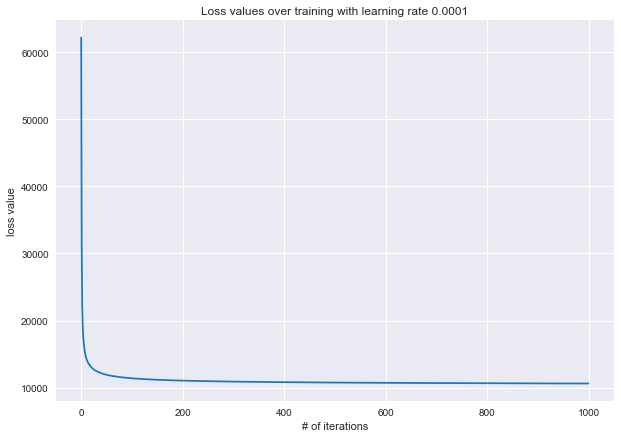

In [12]:

fig1 = plt.figure()
plt.plot(losses_min)      
plt.title("Loss values over training with learning rate {0}".format(best_lr), size=12)
plt.xlabel('# of iterations')
plt.ylabel('loss value')
plt.show()


## Testing & Evaluation

In [13]:


accuracy, prob, prede = accuracy_func(X_train_pca,y_train)
print('Training Accuracy: {0:.3f} %'.format(accuracy))

accuracy_v, prob_v,pred_v = accuracy_func(X_val_pca,y_val)
print('Validation Accuracy: {0:.3f} %'.format(accuracy_v))

Training Accuracy: 86.393 %
Validation Accuracy: 84.067 %


## Classification Report

In [14]:

print('Predicting items\' label on the test set')
accuracy_t, prob_t,pred_t = accuracy_func(X_test_pca,y_test)
print ('Test Accuracy: {0:.3f} %'.format(accuracy_t))
print ('Misclassification Rate: {0:.3f}'.format(1 - metrics.accuracy_score(y_test, pred_t)))

print('\n\033[1mAccuracy by class')
print('\033[0m')
#Accuracy by class
accuracy_class_func(pred_t)


print('\n\033[1mClassification Report')
print('\033[0m')
print(classification_report(y_test, pred_t))

print('\n\033[1mConfusion Matrix')
print('\033[0m')
print(confusion_matrix(y_test, pred_t ))



Predicting items' label on the test set
Test Accuracy: 81.800 %
Misclassification Rate: 0.182

Accuracy by class

Class 0 Accuracy: 79.775 %
Class 1 Accuracy: 96.859 %
Class 2 Accuracy: 70.952 %
Class 3 Accuracy: 88.482 %
Class 4 Accuracy: 72.642 %
Class 5 Accuracy: 86.916 %
Class 6 Accuracy: 48.000 %
Class 7 Accuracy: 87.374 %
Class 8 Accuracy: 91.781 %
Class 9 Accuracy: 96.791 %

Classification Report

             precision    recall  f1-score   support

          0       0.76      0.80      0.78       178
          1       0.98      0.97      0.97       191
          2       0.74      0.71      0.73       210
          3       0.78      0.88      0.83       191
          4       0.68      0.73      0.70       212
          5       0.91      0.87      0.89       214
          6       0.60      0.48      0.53       200
          7       0.93      0.87      0.90       198
          8       0.93      0.92      0.92       219
          9       0.86      0.97      0.91       187

avg / t

Comparing actual and prediction result for a sample observation in the testing set


Full Dimension Observations/Actual Y -vs- Reduced Dimensionality Observations/Predicted Y



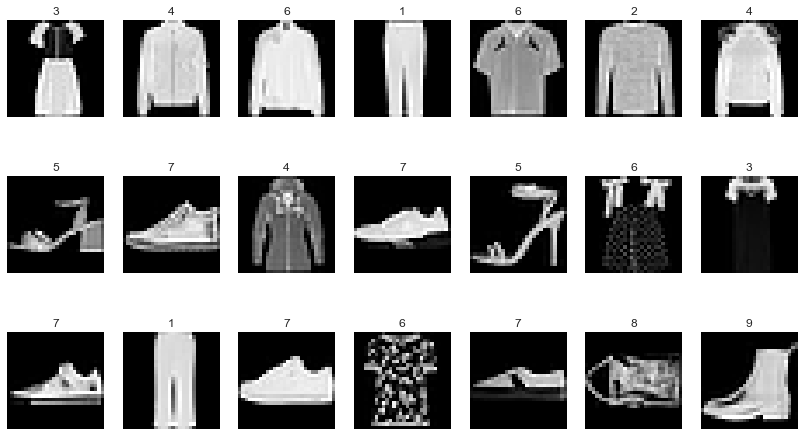

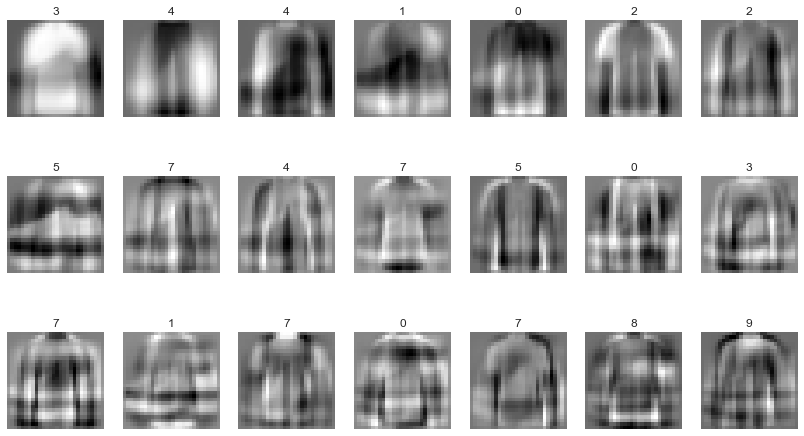

In [15]:

n_col = 7
n_row = 3
fig2 = plt.figure(figsize=(1.6 * n_col, 2.2 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
plot_gallery(X_test,  y_test, h, d, n_row, n_col)

print('\n\033[1mFull Dimension Observations/Actual Y -vs- Reduced Dimensionality Observations/Predicted Y')
print('\033[0m')

fig3 = plt.figure(figsize=(1.6 * n_col, 2.2 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
plot_gallery(eigen_comp_t,  pred_t, h, d, n_row, n_col)


## Output the Result
Output the prediction results on the full test set 

In [16]:
prob , pred = prob_pred_func(X_test_full_pca)
pred.shape

(5000,)

In [17]:

# output predicted labels for 5000 observations in test dataset
with h5py.File('Output/predicted_labels_Softmax.h5','w') as H:
    H.create_dataset('label',data=pred)

# Navie Bayes Implementaion

In [18]:
def p_x_given_y(x, mean, variance):
        exponent = math.exp(-(math.pow(x - mean, 2) / (2 * variance)))
        return (1 / (math.sqrt(2 * math.pi * variance))) * exponent

def run():
    predicted_val = []
    predicted_temp = []
    for k in range(X_val_pca.shape[0]):
        predicted_val = np.append(predicted_val, predicted_temp)
        temp1 = 0
        temp2 = 0
        for i in range(len(set(y_val))):
            if temp2 > temp1:
                temp1 = temp2
                predicted_temp = i - 1
                temp2 = globals()["P_" + str(i)]    
            for j in range(X_val_pca.shape[1]):
                mean = df_means['F_' + str(j+1)][df_means.index == i].values[0]
                variance = df_variance['F_' + str(j+1)][df_variance.index == i].values[0]
                temp2 = temp2 * p_x_given_y(df_val["F_" + str(j+1)][k], mean, variance)


## Feature Selection 
Specifying the number of most effective features base on the validation set accuracy result.

In [19]:
t0 = time()
accuracy_val = []

for n in [10,20,30,40,50,60]:
    X_train_pca, eigen_comp = pca_func(X_train,h,d,n,'training')
    X_val_pca , eigen_comp_v= pca_func(X_val,h,d,n,'validation')
    # Calculate Prior
    # Number of outcomes for each label
    for i in range(10):
        globals()["n_" + str(i)] =  y_train[y_train == i].shape[0]  

    # Total rows
    n_total = y_train.shape[0]

    # Calculate the probability outcomes for each lables
    for i in range(10):
        globals()["P_" + str(i)] = globals()["n_" + str(i)] / n_total  


    # Combine X and Y for training data set    
    df = pd.DataFrame({'label': y_train}, columns=['label'])

    for i in range(n):
        df["F_" + str(i+1)] = [item[i] for item in X_train_pca]

    # Group the data by label and calculate the means of each feature
    df_means = df.groupby('label').mean()

    # Group the data by label and calculate the variance of each feature
    df_variance = df.groupby('label').var()

    # Combine X and Y for validation data set
    df_val = pd.DataFrame({'label': y_val}, columns=['label'])

    for i in range(n):
        df_val["F_" + str(i+1)] = [item[i] for item in X_val_pca]

    #Calculate the numerators of the posteriors
    def p_x_given_y(x, mean_y, variance_y):
        # Input the arguments into a probability density function
        p = 1/(np.sqrt(2*np.pi*variance_y)) * np.exp((-(x-mean_y)**2)/(2*variance_y))
        return p

    predicted_val = []
    predicted_temp = []
    for k in range(X_val_pca.shape[0]):
        predicted_val = np.append(predicted_val, predicted_temp)
        temp1 = 0
        temp2 = 0
        predicted_temp = []

        for i in range(len(set(y_val))):           
            temp2 = globals()["P_" + str(i)]  
            for j in range(X_val_pca.shape[1]):
                mean = df_means['F_' + str(j+1)][df_means.index == i].values[0]
                variance = df_variance['F_' + str(j+1)][df_variance.index == i].values[0]
                temp2 = temp2 * p_x_given_y(df_val["F_" + str(j+1)][k], mean, variance)            
            if temp2 > temp1:
                temp1 = temp2
                predicted_temp = i  

    predicted_val = np.append(predicted_val, predicted_temp)
    accuracy_temp = len(y_val[y_val == predicted_val])/ len(y_val)
    accuracy_val = np.append(accuracy_val, accuracy_temp)

print(accuracy_val)
print("Feature selection done in {0:.3f}s".format((time() - t0)))

Projecting training set input data on a lower dimensional linear space
Projecting validation set input data on a lower dimensional linear space
Projecting training set input data on a lower dimensional linear space
Projecting validation set input data on a lower dimensional linear space
Projecting training set input data on a lower dimensional linear space
Projecting validation set input data on a lower dimensional linear space
Projecting training set input data on a lower dimensional linear space
Projecting validation set input data on a lower dimensional linear space
Projecting training set input data on a lower dimensional linear space
Projecting validation set input data on a lower dimensional linear space
Projecting training set input data on a lower dimensional linear space
Projecting validation set input data on a lower dimensional linear space
[0.70466667 0.752      0.76733333 0.764      0.768      0.77233333]
Feature selection done in 2135.903s


# Assumption Validation
Check the validity of the normality assumption on the dataset

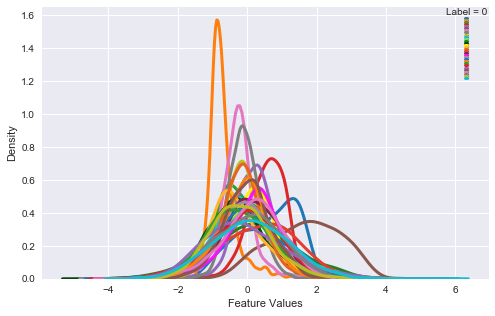

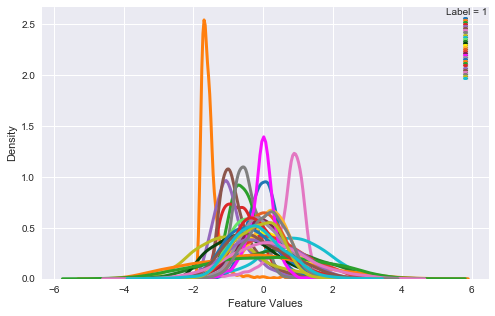

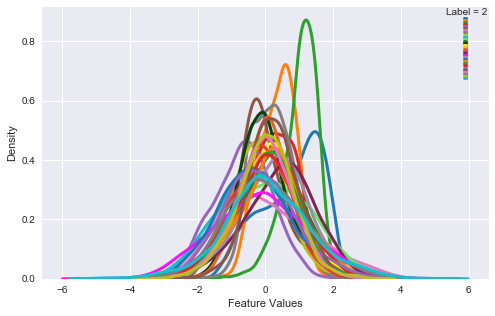

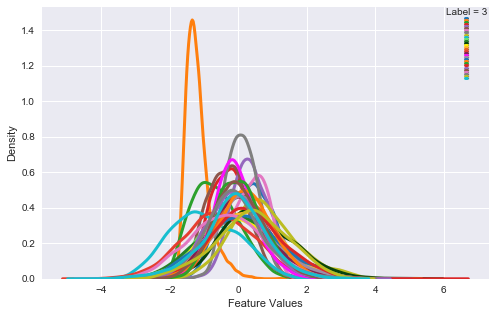

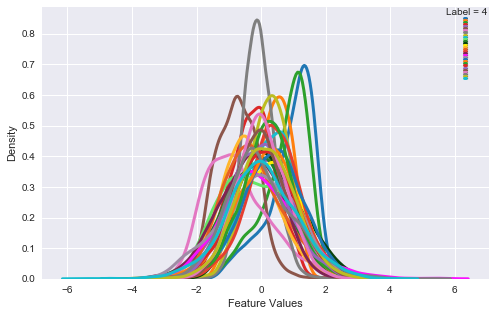

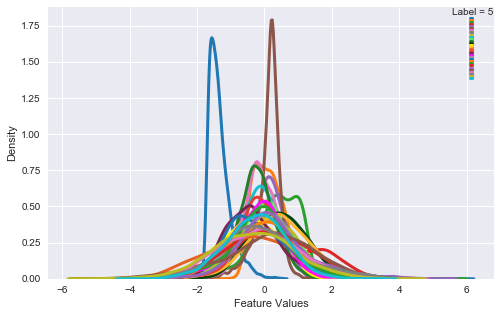

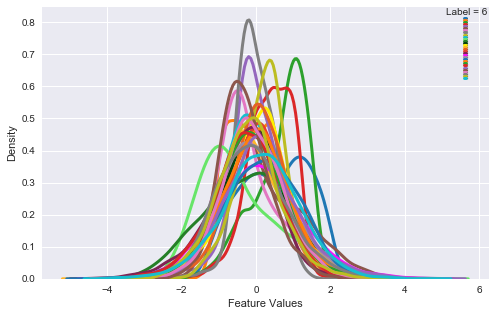

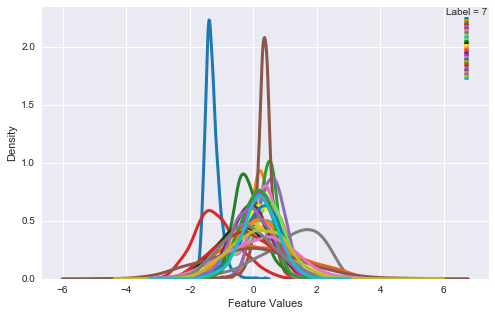

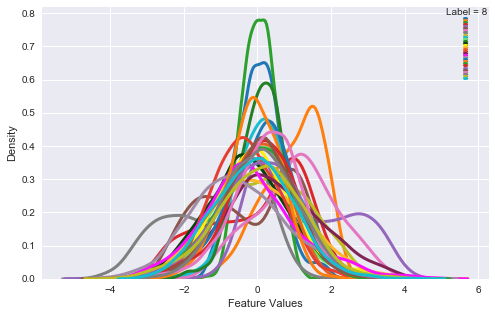

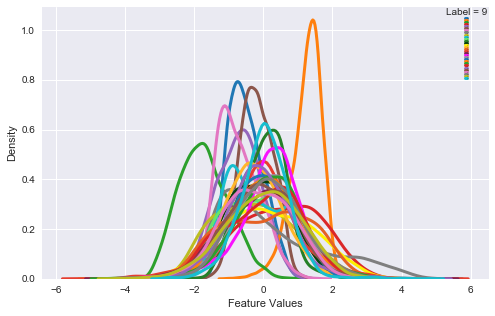

In [20]:
for j in range(10):  
    fig, ax = plt.subplots(figsize=(8,5))   
    for i in range(30):       
        # Subset by class
        subset = df[df['label'] == j]    
        # Draw the density plot
        sns.distplot(subset["F_" + str(i+1)], hist = False, kde = True,
                     kde_kws = {'linewidth': 3},
                     label = "F_" + str(i+1))

    # Plot formatting
    plt.legend(prop={'size': 1}, title = 'Label = ' + str(j))
    plt.xlabel('Feature Values')
    plt.ylabel('Density')

## Compute Accuracy 
Compute and validate the model using training and validation data set based on selected number of feature from the previous step (30 features)

In [21]:
t0 = time()

for n in [30]:
    X_train_pca, eigen_comp = pca_func(X_train,h,d,n,'training')
    X_test_pca, eigen_comp_t = pca_func(X_test,h,d,n,'test')

    # Calculate Prior
    # Number of outcomes for each label
    for i in range(10):
        globals()["n_" + str(i)] =  y_train[y_train == i].shape[0]  

    # Total rows
    n_total = y_train.shape[0]

    # Calculate the probability outcomes for each lables
    for i in range(10):
        globals()["P_" + str(i)] = globals()["n_" + str(i)] / n_total  

    # Combine X and Y for training data set    
    df = pd.DataFrame({'label': y_train}, columns=['label'])
    for i in range(n):
        df["F_" + str(i+1)] = [item[i] for item in X_train_pca]

    # Group the data by label and calculate the means of each feature
    df_means = df.groupby('label').mean()

    # Group the data by label and calculate the variance of each feature
    df_variance = df.groupby('label').var()

    # Combine X and Y for Test data set
    df_test = pd.DataFrame({'label': y_test}, columns=['label'])

    for i in range(n):
        df_test["F_" + str(i+1)] = [item[i] for item in X_test_pca]

    #Calculate the numerators of the posteriors
    def p_x_given_y(x, mean_y, variance_y):
        # Input the arguments into a probability density function
        p = 1/(np.sqrt(2*np.pi*variance_y)) * np.exp((-(x-mean_y)**2)/(2*variance_y))
        return p

    predicted_test = []
    predicted_temp = []

    for k in range(X_test_pca.shape[0]):
        predicted_test = np.append(predicted_test, predicted_temp)
        temp1 = 0
        temp2 = 0
        predicted_temp = []

        for i in range(len(set(y_test))):            
            temp2 = globals()["P_" + str(i)]              
            for j in range(X_test_pca.shape[1]):
                mean = df_means['F_' + str(j+1)][df_means.index == i].values[0]
                variance = df_variance['F_' + str(j+1)][df_variance.index == i].values[0]
                temp2 = temp2 * p_x_given_y(df_test["F_" + str(j+1)][k], mean, variance)            
            if temp2 > temp1:
                temp1 = temp2
                predicted_temp = i  

    predicted_test = np.append(predicted_test, predicted_temp)
    
accuracy_test = len(y_test[y_test == predicted_test])/ len(y_test)
print(accuracy_test)
print("Training done in {0:.3f}s".format((time() - t0)))

Projecting training set input data on a lower dimensional linear space
Projecting test set input data on a lower dimensional linear space
0.7505
Training done in 226.842s


## Classification Report

In [22]:
print('\n\033[1mAccuracy by class')
print('\033[0m')
#Accuracy by class
accuracy_class_func(predicted_test)


print('\n\033[1mClassification Report')
print('\033[0m')
print(classification_report(y_test, predicted_test))

print('\n\033[1mConfusion Matrix')
print('\033[0m')
print(confusion_matrix(y_test, predicted_test))



Accuracy by class

Class 0 Accuracy: 73.596 %
Class 1 Accuracy: 90.576 %
Class 2 Accuracy: 62.857 %
Class 3 Accuracy: 83.770 %
Class 4 Accuracy: 66.509 %
Class 5 Accuracy: 71.963 %
Class 6 Accuracy: 42.000 %
Class 7 Accuracy: 85.859 %
Class 8 Accuracy: 83.562 %
Class 9 Accuracy: 92.513 %

Classification Report

             precision    recall  f1-score   support

          0       0.69      0.74      0.71       178
          1       1.00      0.91      0.95       191
          2       0.66      0.63      0.65       210
          3       0.76      0.84      0.80       191
          4       0.70      0.67      0.68       212
          5       0.79      0.72      0.75       214
          6       0.43      0.42      0.42       200
          7       0.78      0.86      0.82       198
          8       0.88      0.84      0.86       219
          9       0.83      0.93      0.88       187

avg / total       0.75      0.75      0.75      2000


Confusion Matrix

[[131   0   4  20   2   1  1

## Output the Result
Predict the lables for the full test dataset and output the results (5000 observations)

In [ ]:
for n in [30]:
    X_train_pca, eigen_comp = pca_func(X_train,h,d,n,'training')
    X_test_full_pca, eigen_comp_t = pca_func(X_test_full,h,d,n,'full test')

    # Calculate Prior
    # Number of outcomes for each label
    for i in range(10):
        globals()["n_" + str(i)] =  y_train[y_train == i].shape[0]  

    # Total rows
    n_total = y_train.shape[0]

    # Calculate the probability outcomes for each lables
    for i in range(10):
        globals()["P_" + str(i)] = globals()["n_" + str(i)] / n_total  

    # Combine X and Y for training data set    
    df = pd.DataFrame({'label': y_train}, columns=['label'])

    for i in range(n):
        df["F_" + str(i+1)] = [item[i] for item in X_train_pca]

    # Group the data by label and calculate the means of each feature
    df_means = df.groupby('label').mean()

    # Group the data by label and calculate the variance of each feature
    df_variance = df.groupby('label').var()

    # Combine X and Y for Test data set   
    df_test_full = pd.DataFrame()
    
    for i in range(n):
        df_test_full["F_" + str(i+1)] = [item[i] for item in X_test_full_pca]

    #Calculate the numerators of the posteriors
    def p_x_given_y(x, mean_y, variance_y):

        # Input the arguments into a probability density function
        p = 1/(np.sqrt(2*np.pi*variance_y)) * np.exp((-(x-mean_y)**2)/(2*variance_y))
        return p

    predicted_test_full = []
    predicted_temp = []

    for k in range(X_test_full_pca.shape[0]):
        predicted_test_full = np.append(predicted_test_full, predicted_temp)
        temp1 = 0
        temp2 = 0
        predicted_temp = []
        for i in range(len(set(y_test))):            
            temp2 = globals()["P_" + str(i)]              
            for j in range(X_test_full_pca.shape[1]):
                mean = df_means['F_' + str(j+1)][df_means.index == i].values[0]
                variance = df_variance['F_' + str(j+1)][df_variance.index == i].values[0]
                temp2 = temp2 * p_x_given_y(df_test_full["F_" + str(j+1)][k], mean, variance)
             
            if temp2 > temp1:
                temp1 = temp2
                predicted_temp = i  

    predicted_test_full = np.append(predicted_test_full, predicted_temp)

Projecting training set input data on a lower dimensional linear space
Projecting full test set input data on a lower dimensional linear space


In [ ]:
# output predicted labels for 5000 observations in test dataset
with h5py.File('Output/predicted_labels_Naive.h5','w') as H:
    H.create_dataset('label',data=predicted_test_full)